In [105]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd
import scipy
from tqdm.notebook import tqdm
import dill

import torch
import torch.distributions as dist

import gpytorch
from gpytorch.models import ApproximateGP
from gpytorch.variational import CholeskyVariationalDistribution
from gpytorch.variational import VariationalStrategy, UnwhitenedVariationalStrategy
from gpytorch.likelihoods.likelihood import _OneDimensionalLikelihood

from pymc3.gp.util import plot_gp_dist

In [2]:
%config InlineBackend.figure_format = "retina"
sns.set()

# Utility models

In [3]:
def u_pow(x, theta): return x**theta

In [4]:
def u_exp(x, theta): return 1 - np.exp(-theta*x)

In [5]:
def u_lin(x, theta=None): return x

# Generate choice data

In [6]:
def generate_data(u, seed=123, max_x=1, n=100, tau=3.333, theta=0.5):
    
    np.random.seed(seed)
    
    data = pd.DataFrame(np.random.uniform(0, 1, size=(n*10, 4)), columns=["p0", "x0", "p1", "x1"])
    for i in range(2):
        data[f"x{i}"] = data[f"x{i}"].values * max_x
    data = data[~((data.p0 >= data.p1) & (data.x0 >= data.x1))]
    data = data[~((data.p1 >= data.p0) & (data.x1 >= data.x0))]
    data = data.sample(n=n, replace=False)
    
    p0 = data.p0.values
    p1 = data.p1.values
    x0 = data.x0.values
    x1 = data.x1.values
    
    seu0 = p0 * u(x0, theta)
    seu1 = p1 * u(x1, theta)

    diff_eu = seu1 - seu0

    p_choice_1 = scipy.special.expit(tau*diff_eu)
    choices = np.zeros(n, dtype=int)
    choices[:] = p_choice_1 > np.random.random(size=n)
    data['choices'] = choices

    return data

# Inference cognitive model's parameters

In [7]:
def softplus(x): return np.log(1 + np.exp(x))

def objective(param, data, u_m):
    
    param = softplus(param)  # All parameters all supposed to be R+
    
    tau = param[0]
    theta = param[1]
    
    p0 = data.p0.values
    p1 = data.p1.values
    x0 = data.x0.values
    x1 = data.x1.values
    y = data.choices.values 
    
    seu0 = p0 * u_m(x0, theta)
    seu1 = p1 * u_m(x1, theta)

    diff_eu = seu1 - seu0

    p_choice_1 = scipy.special.expit(tau*diff_eu) # p choose 1
    p_choice_y = p_choice_1**y * (1-p_choice_1)**(1-y)
    return - np.log(p_choice_y).sum()

In [8]:
def optimize(data, u_m=u_pow, x0=None):
    
    if x0 is None:
        x0 = (0.0, 0.0) # Assume two parameters
    opt = scipy.optimize.minimize(objective, x0=x0, args=(data, u_m))
    return softplus(opt.x)

# Discrepancy modeling

In [9]:
class GPClassificationModel(ApproximateGP):
    
    def __init__(self, inducing_points, learn_inducing_locations):
    
        variational_distribution = CholeskyVariationalDistribution(inducing_points.size(0))
        variational_strategy = VariationalStrategy(
            self, inducing_points, variational_distribution, 
            learn_inducing_locations=learn_inducing_locations)
        super(GPClassificationModel, self).__init__(variational_strategy)
        self.mean_module = gpytorch.means.ZeroMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())

    def forward(self, x):
    
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        latent_pred = gpytorch.distributions.MultivariateNormal(mean_x, covar_x)
        return latent_pred

In [10]:
class UMeanFunc(gpytorch.means.mean.Mean):
    
    def __init__(self, u, theta, h_prime):
        
        super().__init__()
        self.u = u
        self.theta = theta
        self.h_prime = h_prime
    
    def forward(self, x):
        
        return self.h_prime(self.u(x.squeeze(-1), self.theta))        

In [41]:
class DiscrepancyModel:
    
    def __init__(
            self, data, u, theta, h, tau,                   
            learn_inducing_locations=False, jitter=1e-07,
            n_samples=40, 
            n_inducing_points=50, n_max_cholesky_increase=1000):
        
        if h == torch.sigmoid:
            h_prime = torch.logit
        elif h == torch.exp:
            h_prime = lambda x: torch.log(x + 1e-07)
        else:
            raise ValueError
            
        self.n_output_total = len([c for c in data.columns if c.startswith("x")])

        x = np.hstack([data[f"x{i}"].values for i in range(self.n_output_total)])
        p = np.hstack([data[f"p{i}"].values for i in range(self.n_output_total)])
        y = data.choices.values
        
        x_order = np.argsort(x)
        x_sorted = x[x_order]
        p_sorted = p[x_order]
        
        # We assume that there are 2 lotteries with `n_output_per_lot` each
        self.n_output_per_lot = self.n_output_total // 2
        
        self.init_order = np.argsort(x_order)

        self.train_x = torch.from_numpy(x_sorted.astype(np.float32))
        self.train_p = torch.from_numpy(p_sorted.astype(np.float32))
        self.train_y = torch.from_numpy(y.astype(np.float32))

        self.u = u
        self.theta = theta
        self.tau = tau
        
        self.h = h
        self.h_prime = h_prime

        self.n_samples = n_samples
        
        self.n_x = self.train_x.size(0)
        self.n_y = self.train_y.size(0)
        
        self.jitter = jitter

        self.h_prime_m = self.h_prime(u(self.train_x, self.theta))
        
        self.r_model = GPClassificationModel(
            inducing_points=torch.linspace(0, 1, n_inducing_points),
            learn_inducing_locations=learn_inducing_locations)
        
        self.n_max_cholesky_increase = 1000
        
    def expected_log_prob(self, observations, function_dist):
        
        n_try = 0
        jitter = self.jitter
        while n_try < self.n_max_cholesky_increase:
            try:
                L = torch.linalg.cholesky(function_dist.covariance_matrix + torch.eye(self.n_x) * jitter)
                break
            except RuntimeError:
                jitter += 1e-04
                
        gp_mean = function_dist.loc
        eta = torch.randn(self.n_x, self.n_samples)
        L_eta = L@eta 
        r = gp_mean + L_eta.T
        
        f = self.h(self.h_prime_m + r)
        
        est_eu_sorted =  self.train_p * f  
        est_eu = est_eu_sorted[:, self.init_order]
        
        est_eu = est_eu.reshape(self.n_samples, self.n_output_total, self.n_y)

        est_diff_eu = est_eu[:, self.n_output_per_lot:, :].sum(axis=1) \
            - est_eu[:, :self.n_output_per_lot, :].sum(axis=1)
        
        log_prob = dist.Bernoulli(logits=self.tau*est_diff_eu).log_prob(observations).mean(0)
        return log_prob
    
    def train(self, learning_rate=0.05, epochs=1000):
    
        # Switch to 'train' mode
        self.r_model.train()

        # Use the adam optimizer
        optimizer = torch.optim.Adam(self.r_model.parameters(), lr=learning_rate)

        # Loss function
        mll = gpytorch.mlls.VariationalELBO(self, self.r_model, self.train_y.numel())

        hist_loss = []

        with tqdm(total=epochs) as pbar: 
            for i in range(epochs):
                # Zero backpropped gradients from previous iteration
                optimizer.zero_grad()
                # Get predictive output
                output = self.r_model(self.train_x)
                # Calc loss and backprop gradients
                loss = -mll(output, self.train_y)
                loss.backward()
                optimizer.step()

                hist_loss.append(loss.item())
                
                pbar.set_postfix(loss=loss.item())
                pbar.update()

        return hist_loss
    
    def pred(self, test_x, n_sample=1000):
        
        # Switch to 'eval' mode
        self.r_model.eval()

        r_preds = self.r_model(test_x).sample(torch.Size((n_sample,)))
        
        h_prime_m = self.h_prime(self.u(test_x, self.theta))
        
        f_preds = self.h(h_prime_m + r_preds)
        
        return f_preds

# Run

In [42]:
u_model = u_pow
theta = 0.5
tau = 100
n = 200
data = generate_data(u=u_model, n=n, tau=tau, theta=theta)
data

,p0,x0,p1,x1,choices
308,0.710046,0.972624,0.916240,0.971488,1
771,0.254806,0.549418,0.933566,0.436220,1
1168,0.846783,0.135510,0.504619,0.547520,1
977,0.800907,0.270393,0.591541,0.534649,1
852,0.832668,0.260333,0.366150,0.920683,0
...,...,...,...,...,...
1322,0.834019,0.068404,0.111335,0.536288,0
824,0.012429,0.509863,0.981862,0.232335,1
1028,0.018290,0.849445,0.396082,0.844821,1
1246,0.338320,0.925665,0.968984,0.663299,1


## Good prior

In [43]:
model = DiscrepancyModel(
    data=data, u=u_model, theta=theta, tau=tau,  h=torch.sigmoid, n_samples=100,
    learn_inducing_locations=False, n_inducing_points=50)

In [44]:
hist_loss = model.train(
    epochs=1000,
    learning_rate=0.1)

  0%|          | 0/1000 [00:00<?, ?it/s]

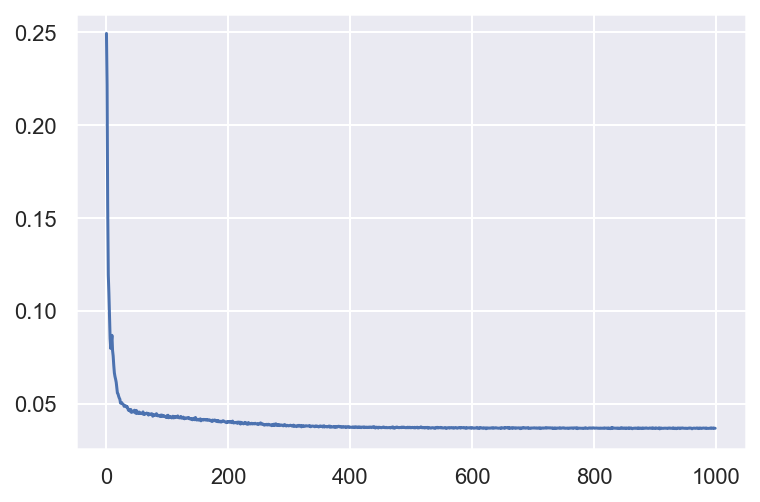

In [46]:
plt.plot(hist_loss);

In [47]:
test_x = torch.linspace(0, 1, 101)
f_preds = model.pred(test_x)

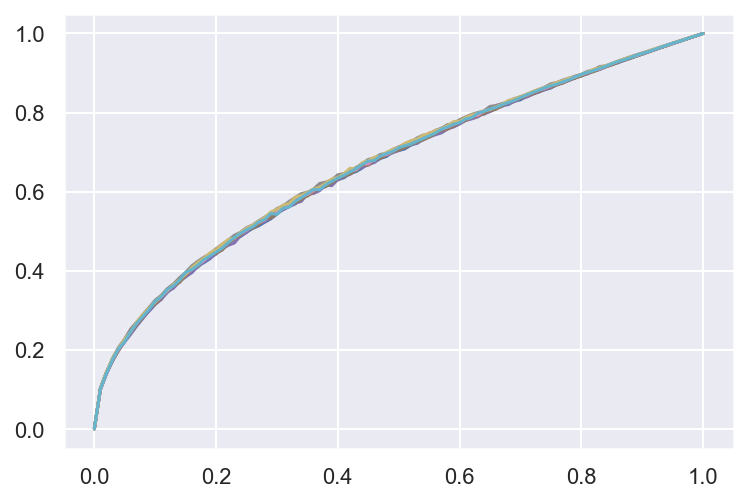

In [48]:
fig, ax = plt.subplots()
for i in range(10):
    ax.plot(test_x, f_preds[i])

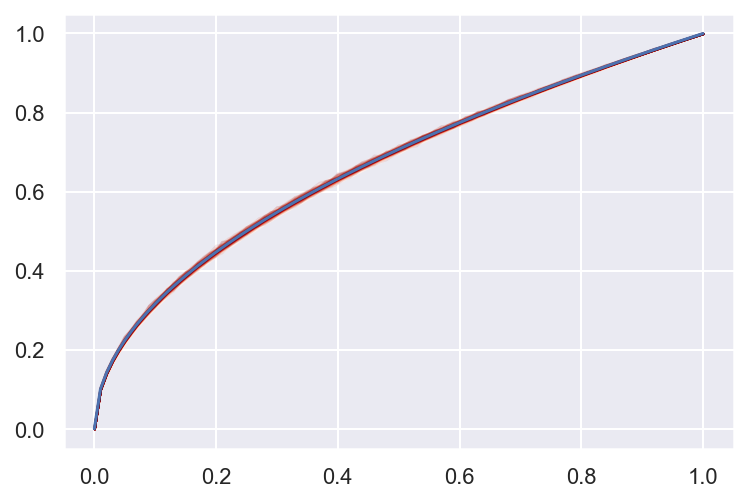

In [49]:
fig, ax = plt.subplots()
plot_gp_dist(ax, f_preds.numpy(), test_x)
ax.plot(test_x, u_model(test_x, theta));

## Wrong prior

In [50]:
model = DiscrepancyModel(
    data=data, 
    u=u_lin,  # Here is the change!
    theta=theta, tau=tau,  h=torch.sigmoid, n_samples=100,
    learn_inducing_locations=False, n_inducing_points=50)

In [51]:
hist_loss = model.train(
    epochs=1000,
    learning_rate=0.1)

  0%|          | 0/1000 [00:00<?, ?it/s]

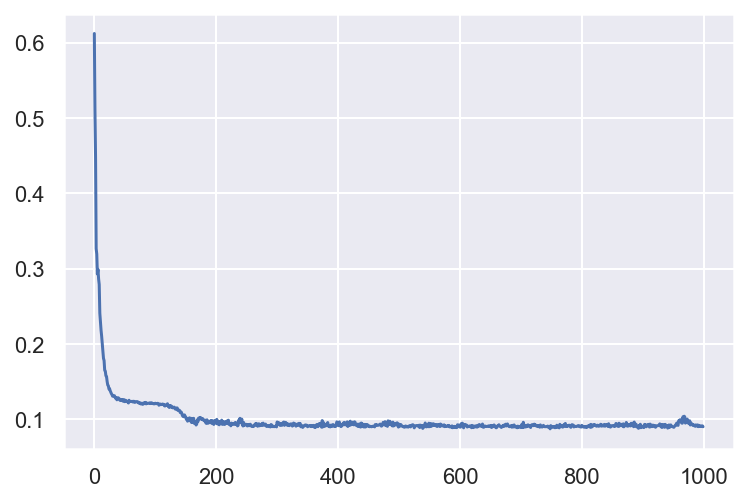

In [53]:
plt.plot(hist_loss);

In [54]:
test_x = torch.linspace(0, 1, 101)
f_preds = model.pred(test_x)

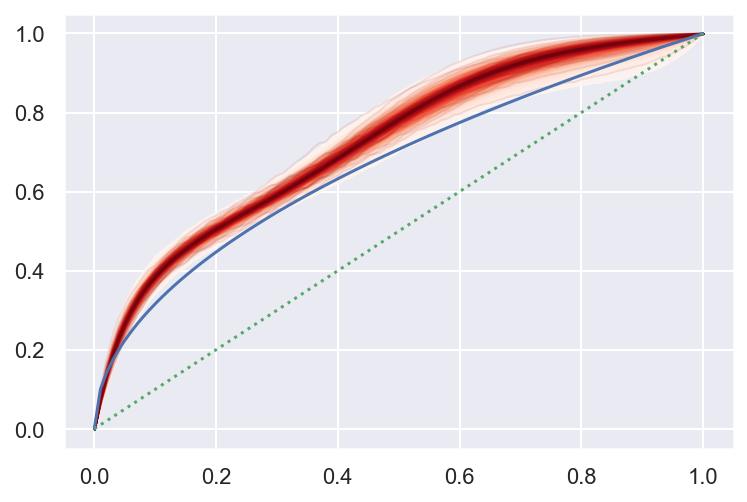

In [55]:
fig, ax = plt.subplots()
plot_gp_dist(ax, f_preds.numpy(), test_x)
ax.plot(test_x, u_model(test_x, theta))
ax.plot(test_x, u_lin(test_x, None), ls=':', color='C2');

# Using CPC dataset

## Generate artificial data

In [12]:
def generate_data_cpc_like(u, seed=123, n=100, tau=3.333, theta=0.5):
    
    np.random.seed(seed)

    data = pd.DataFrame(np.zeros((n*10, 8)), 
                        columns=[f"p{i}" for i in range(4)] + [f"x{i}" for i in range(4)])
    
    j = 0
    for opt in range(2):
        p = np.random.random(size=n*10) 
        
        data[f'p{j}'] = p
        data[f'p{j+1}'] = 1 - p
        
        a = np.random.random(size=(n*10, 2))
        a = np.sort(-a, -1)*(-1)

        data[f'x{j}'] = a[:, 0]
        data[f'x{j+1}'] = a[:, 1]
            
        j += 2
            
    data = data[~((data.p0 >= data.p2) & (data.x0 >= data.x2))]
    data = data[~((data.p2 >= data.p0) & (data.x2 >= data.x0))]
    data = data.sample(n=n, replace=False)
    
    pA = data.p0.values
    pB = data.p2.values

    xA0 = data.x0.values
    xA1 = data.x1.values

    xB0 = data.x2.values
    xB1 = data.x3.values
    
    seuA = pA * u(xA0, theta) + (1-pA) * u(xA1, theta)
    seuB = pB * u(xB0, theta) + (1-pB) * u(xB1, theta)

    diff_eu = seuB - seuA

    p_chooseB = scipy.special.expit(tau * diff_eu)
    choices = np.zeros(n, dtype=int)
    choices[:] = p_chooseB > np.random.random(size=n)
    data['choices'] = choices

    return data

## Fit the data with 'expert' model

In [13]:
def prelec(p, theta): return np.exp(-(-np.log(p))**theta)

def objective(data, u, w):
    
    pA = data.p0.values
    pB = data.p2.values

    xA0 = data.x0.values
    xA1 = data.x1.values

    xB0 = data.x2.values
    xB1 = data.x3.values

    y = data.choices.values 
    
    def run(param):
        
        tau = softplus(param[0])
        theta_u = softplus(param[1])
        
        if w is not None:
            theta_w = expit(param[2])
            wpA = w(pA, theta_w)
            wpB = w(pB, theta_w)
        
        else:
            wpA = pA
            wpB = pB
        
        uxA0 = u(xA0, theta_u)
        uxA1 = u(xA1, theta_u)
        uxB0 = u(xB0, theta_u)
        uxB1 = u(xB1, theta_u)

        seuA = wpA * uxA0 + (1-wpA) * uxA1
        seuB = wpB * uxB0 + (1-wpB) * uxB1

        diff_seu = seuB - seuA

        p_choice_B = scipy.special.expit(tau*diff_seu)
        p_choice_y = p_choice_B**y * (1-p_choice_B)**(1-y)

        lls = np.log(p_choice_y + np.finfo(float).eps).sum()
        return - lls
    return run

def optimize(data, u=u_pow, w=None, seed=12345):
    np.random.seed(seed)
    if w is None:
        opt = scipy.optimize.minimize(objective(data, u, w), x0=np.ones(2))
        theta_w = None
    else:
        opt = scipy.optimize.minimize(objective(data, u, w), x0=np.ones(3))
        theta_w = expit(opt.x[2])
        
    tau = softplus(opt.x[0])
    theta_u = softplus(opt.x[1])
    return tau, theta_u, theta_w

## Run with artificial data

### Generate artificial data

In [55]:
u_model = u_pow
tau = 100
theta = 0.5
n = 200
data = generate_data_cpc_like(u=u_model, tau=tau, theta=theta, n=n)
data

,p0,p1,p2,p3,x0,x1,x2,x3,choices
674,0.328335,0.671665,0.767517,0.232483,0.719289,0.064078,0.520216,0.041979,1
436,0.953818,0.046182,0.328790,0.671210,0.425220,0.086231,0.631256,0.287402,0
426,0.987351,0.012649,0.096225,0.903775,0.176769,0.067219,0.699876,0.682535,1
933,0.015745,0.984255,0.806404,0.193596,0.820461,0.537320,0.631259,0.112848,0
501,0.392304,0.607696,0.871575,0.128425,0.882028,0.181892,0.881193,0.364969,1
...,...,...,...,...,...,...,...,...,...
671,0.002092,0.997908,0.573731,0.426269,0.900329,0.344484,0.787969,0.175919,1
964,0.481115,0.518885,0.828372,0.171628,0.972555,0.653479,0.919383,0.213920,0
1734,0.281660,0.718340,0.652524,0.347476,0.627913,0.518847,0.068779,0.064148,0
180,0.562218,0.437782,0.057695,0.942305,0.276337,0.076794,0.922926,0.501831,1


In [56]:
opt_param = optimize(data, u=u_model, w=None)
tau_opt = opt_param[0]
theta_opt = opt_param[1]
print("tau", tau_opt, "theta_u", theta_opt)

tau 115.55567565183459 theta_u 0.45487383253618446


### Run with good model

In [57]:
model = DiscrepancyModel(
    data=data, 
    u=u_model, 
    theta=theta, tau=tau,  h=torch.sigmoid, n_samples=100,
    learn_inducing_locations=False, n_inducing_points=50)

In [58]:
hist_loss = model.train(
    epochs=1000,
    learning_rate=0.1)

  0%|          | 0/1000 [00:00<?, ?it/s]

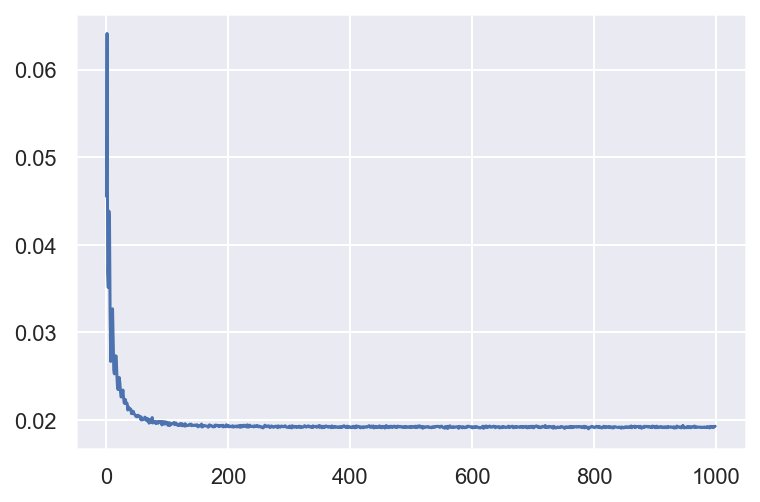

In [59]:
plt.plot(hist_loss);

In [60]:
test_x = torch.linspace(0, 1, 100)
f_preds = model.pred(test_x)

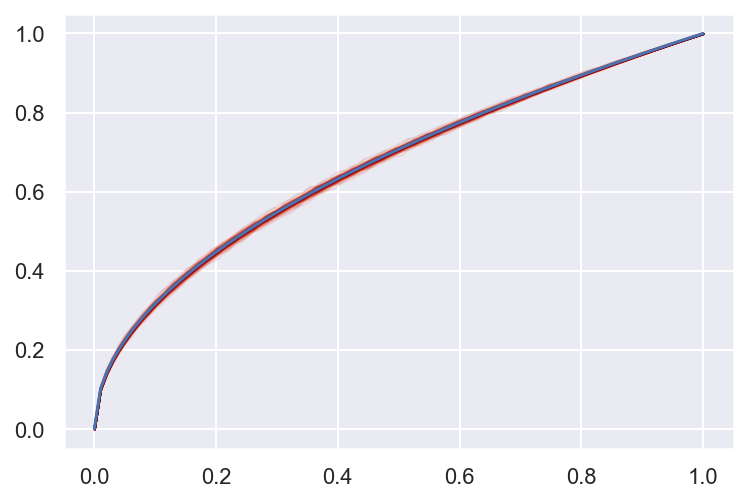

In [61]:
fig, ax = plt.subplots()
plot_gp_dist(ax, f_preds.numpy(), test_x)
ax.plot(test_x, u_model(test_x, theta));

### Run with wrong model

In [62]:
model = DiscrepancyModel(
    data=data, 
    u=u_lin,  # Here is the change!
    theta=theta, tau=tau,  h=torch.sigmoid, n_samples=100,
    learn_inducing_locations=False, n_inducing_points=50)

In [63]:
hist_loss = model.train(
    epochs=1000,
    learning_rate=0.1)

  0%|          | 0/1000 [00:00<?, ?it/s]

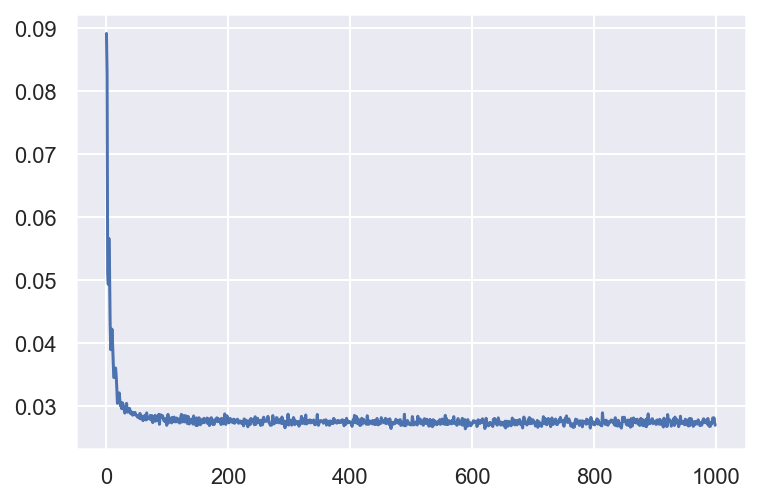

In [64]:
plt.plot(hist_loss);

In [65]:
test_x = torch.linspace(0, 1, 100)
f_preds = model.pred(test_x)

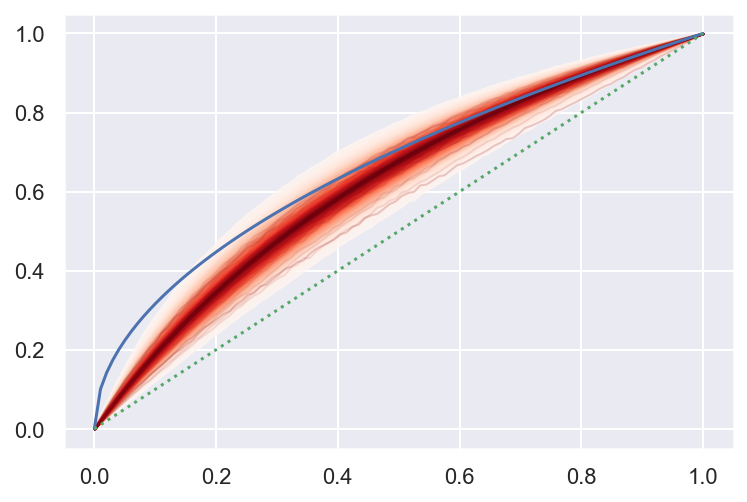

In [66]:
fig, ax = plt.subplots()
plot_gp_dist(ax, f_preds.numpy(), test_x)
ax.plot(test_x, u_model(test_x, theta))
ax.plot(test_x, u_lin(test_x, None), ls=':', color='C2');

## Run with CPC dataset

In [67]:
df = pd.read_csv("../data/cpc2018.csv")

In [68]:
data = df[(df.LotNumB == 1) & (df.LotNumA == 1) & (df.Amb == 0) 
          & (df.Ha >= 0) & (df.Hb >= 0) & (df.La >= 0) & (df.Lb >= 0)]  # & (df.La ==0)  & (df.Lb == 0)

In [69]:
data = pd.DataFrame({
    "subject": data.SubjID,
    "p0": data.pHa.values,
    "x0": data.Ha.values,
    "p1": 1 - data.pHa.values,
    "x1": data.La.values,
    "p2": data.pHb.values,
    "x2": data.Hb.values,
    "p3": 1 - data.pHb.values,
    "x3": data.Lb.values,
    "choices": data.B.values
})
max_x = np.max(np.concatenate([data[f'x{i}'] for i in range(4)]))
for i in range(4):
    data[f'x{i}'] = data[f'x{i}'] / max_x

In [70]:
data

,subject,p0,x0,p1,x1,p2,x2,p3,x3,choices
25,10100,1.0,0.019802,0.0,0.019802,0.5,0.029703,0.5,0.009901,0
26,10100,1.0,0.019802,0.0,0.019802,0.5,0.029703,0.5,0.009901,0
27,10100,1.0,0.019802,0.0,0.019802,0.5,0.029703,0.5,0.009901,0
28,10100,1.0,0.019802,0.0,0.019802,0.5,0.029703,0.5,0.009901,0
29,10100,1.0,0.019802,0.0,0.019802,0.5,0.029703,0.5,0.009901,0
...,...,...,...,...,...,...,...,...,...,...
510395,71109,1.0,0.188119,0.0,0.188119,0.1,0.960396,0.9,0.049505,0
510396,71109,1.0,0.188119,0.0,0.188119,0.1,0.960396,0.9,0.049505,0
510397,71109,1.0,0.188119,0.0,0.188119,0.1,0.960396,0.9,0.049505,0
510398,71109,1.0,0.188119,0.0,0.188119,0.1,0.960396,0.9,0.049505,0


In [71]:
opt_param = optimize(data, u=u_model, w=None)
tau_opt = opt_param[0]
theta_opt = opt_param[1]
print("tau", tau_opt, "theta", theta_opt)

tau 26.720759439803953 theta 0.8174693045702498


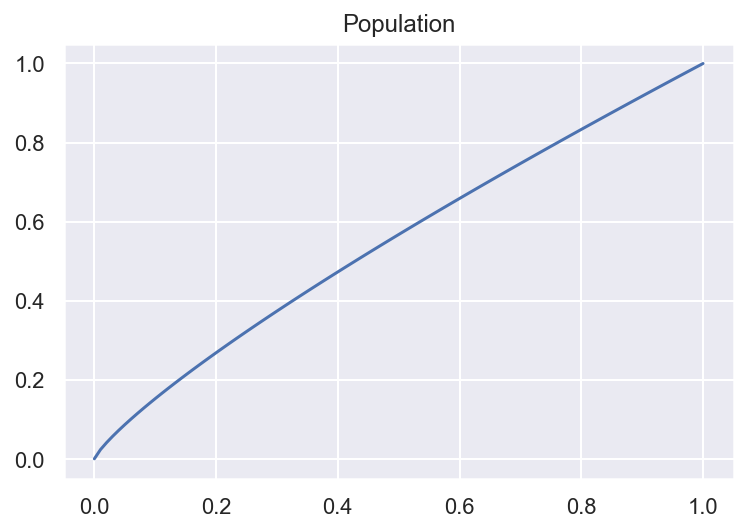

In [72]:
fig, ax = plt.subplots()
ax.set_title(f"Population")
ax.plot(test_x, u_model(test_x, theta_opt))
plt.show()

### Try out with one subject

In [76]:
s = 11303
d = data[data.subject == s]

opt_param = optimize(d, u=u_model, w=None)
tau = opt_param[0]
theta = opt_param[1]
print("tau", tau, "theta", theta)

tau 669.9003783489594 theta 1.1510168681985715


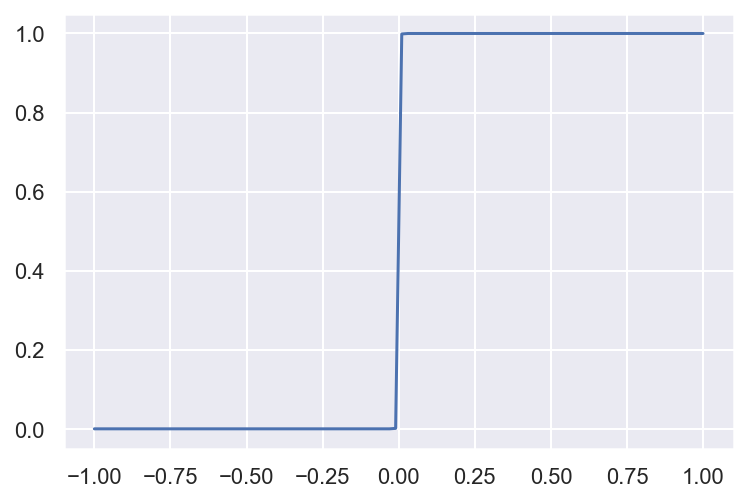

In [77]:
x = np.linspace(-1, 1, 100)
y = scipy.special.expit(tau_opt*x)
plt.plot(x, y);

In [78]:
u = u_model

model = DiscrepancyModel(
    data=d, 
    u=u,
    theta=theta, 
    tau=tau,  
    h=torch.sigmoid, 
    n_samples=100,
    learn_inducing_locations=False, 
    n_inducing_points=50, 
    jitter=1e-07)

hist_loss = model.train(
    epochs=1000,
    learning_rate=0.1)

  0%|          | 0/1000 [00:00<?, ?it/s]

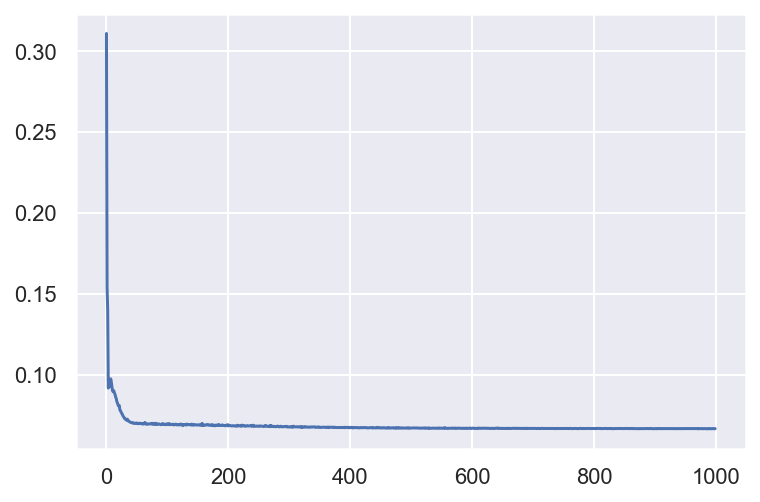

In [79]:
plt.plot(hist_loss)

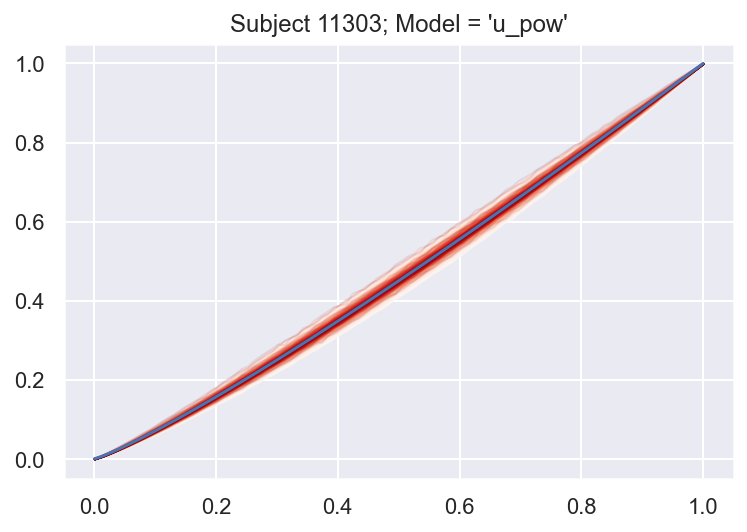

In [80]:
test_x = torch.linspace(0, 1, 100)
f_preds = model.pred(test_x)

fig, ax = plt.subplots()

ax.set_title(f"Subject {s}; Model = '{u.__name__}'")
plot_gp_dist(ax, f_preds.numpy(), test_x)
ax.plot(test_x, u_model(test_x, theta_opt));

In [81]:
u = u_lin

model = DiscrepancyModel(
    data=d, 
    u=u,
    theta=theta, 
    tau=tau,  
    h=torch.sigmoid, 
    n_samples=100,
    learn_inducing_locations=False, 
    n_inducing_points=50, 
    jitter=1e-07)

hist_loss = model.train(
    epochs=1000,
    learning_rate=0.1)

  0%|          | 0/1000 [00:00<?, ?it/s]

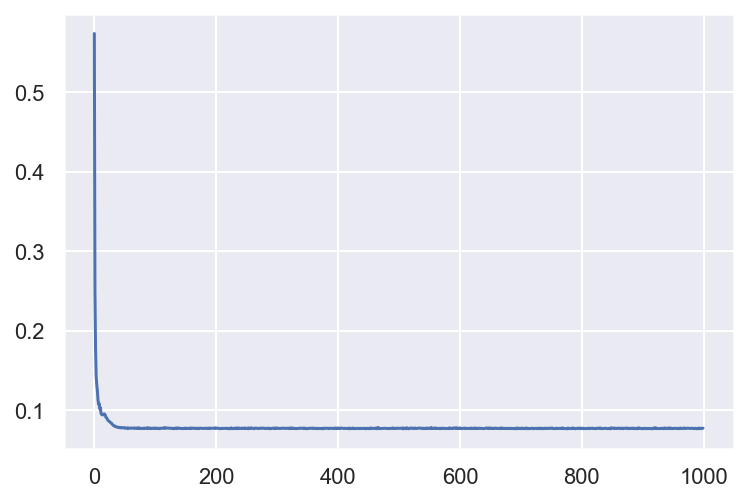

In [85]:
plt.plot(hist_loss);

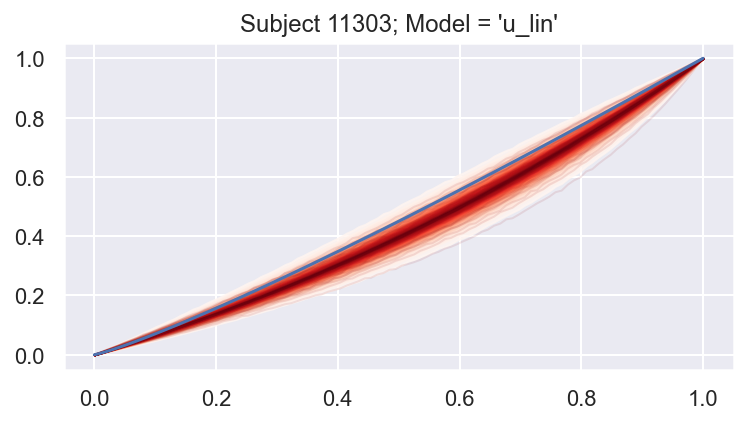

In [90]:
test_x = torch.linspace(0, 1, 100)
f_preds = model.pred(test_x)

fig, ax = plt.subplots(figsize=(6, 3))

ax.set_title(f"Subject {s}; Model = '{u.__name__}'")
plot_gp_dist(ax, f_preds.numpy(), test_x)
ax.plot(test_x, u_model(test_x, theta_opt));

In [ ]:
results = []

counts = data.subject.value_counts()
subject_325 =  counts[counts == 325].index

for s in tqdm(subject_325):
    
    try:
    
        d = data[data.subject == s]

        opt_param = optimize(d, u=u_model, w=None)

        tau = opt_param[0]
        theta = opt_param[1]
        print(f"Subject {s} tau={tau} theta={theta}")

        u = u_model

        model = DiscrepancyModel(
            data=d, 
            u=u,
            theta=theta, 
            tau=tau,  
            h=torch.sigmoid, 
            n_samples=100,
            learn_inducing_locations=False, 
            n_inducing_points=50, 
            jitter=1e-07)

        hist_loss = model.train(
            epochs=1000,
            learning_rate=0.01)

        test_x = torch.linspace(0, 1, 100)
        f_preds = model.pred(test_x)

        fig, ax = plt.subplots(figsize=(6, 3))

        ax.set_title(f"Subject {s}; Model = '{u.__name__}'")
        plot_gp_dist(ax, f_preds.numpy(), test_x)
        ax.plot(test_x, u_model(test_x, theta_opt))

        plt.show()

        results.append({
            "subject": s, 
            "discrepancy_model": dill.dumps(model), 
            "hist_loss": hist_loss, 
            "f_preds": f_preds.numpy(),
            "utility_model": u.__name__,
            "tau": tau,
            "theta": theta
        })
    
    except Exception as e:
        print(f"Encountered error with subject {s}: {e}")

  0%|          | 0/125 [00:00<?, ?it/s]

Subject 11303 tau=669.9003783489594 theta=1.1510168681985715


  0%|          | 0/1000 [00:00<?, ?it/s]

In [ ]:
pd.DataFrame(results).to_csv("results.csv")